<a href="https://colab.research.google.com/github/nafishr24/flight-prediction-kaggle/blob/main/fllight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT PYTHON LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

# **IMPORT THE DATASET**

In [2]:
df = pd.read_csv('goibibo_flights_data.csv')
df

,flight date,airline,flight_num,class,from,dep_time,to,arr_time,duration,price,stops,Unnamed: 11,Unnamed: 12
0,26-06-2023,SpiceJet,SG-8709,economy,Delhi,18:55,Mumbai,21:05,02h 10m,"6,013",non-stop,NaN,NaN
1,26-06-2023,SpiceJet,SG-8157,economy,Delhi,06:20,Mumbai,08:40,02h 20m,"6,013",non-stop,NaN,NaN
2,26-06-2023,AirAsia,I5-764,economy,Delhi,04:25,Mumbai,06:35,02h 10m,"6,016",non-stop,NaN,NaN
3,26-06-2023,Vistara,UK-995,economy,Delhi,10:20,Mumbai,12:35,02h 15m,"6,015",non-stop,NaN,NaN
4,26-06-2023,Vistara,UK-963,economy,Delhi,08:50,Mumbai,11:10,02h 20m,"6,015",non-stop,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
300256,13-08-2023,Vistara,UK-822,business,Chennai,09:45,Hyderabad,19:50,10h 05m,"70,304",1-stop,NaN,NaN
300257,13-08-2023,Vistara,UK-826,business,Chennai,12:30,Hyderabad,22:55,10h 25m,"78,262",1-stop,NaN,NaN
300258,13-08-2023,Vistara,UK-832,business,Chennai,07:05,Hyderabad,20:55,13h 50m,"80,285",1-stop,NaN,NaN
300259,13-08-2023,Vistara,UK-828,business,Chennai,07:00,Hyderabad,17:00,10h 00m,"82,809",1-stop,NaN,NaN


# **EXPLORATORY DATA ANALYSIS (EDA)**

## **Check the number of missing values per column**

In [3]:
missing_counts = df.isnull().sum()
print("Number of missing values per column:\n")
print(missing_counts)

Number of missing values per column:

flight date         0
airline             0
flight_num          0
class               0
from                0
dep_time            0
to                  0
arr_time            0
duration            0
price               0
stops               0
Unnamed: 11    300261
Unnamed: 12    300261
dtype: int64


## **Drop columns that have missing values**

In [4]:
df = df.dropna(axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   flight date  300261 non-null  object
 1   airline      300261 non-null  object
 2   flight_num   300261 non-null  object
 3   class        300261 non-null  object
 4   from         300261 non-null  object
 5   dep_time     300261 non-null  object
 6   to           300261 non-null  object
 7   arr_time     300261 non-null  object
 8   duration     300261 non-null  object
 9   price        300261 non-null  object
 10  stops        300261 non-null  object
dtypes: object(11)
memory usage: 25.2+ MB


## **Convert price to numeric**

In [5]:
df['price'] = df['price'].str.replace(',', '').astype(int)
print(df.dtypes)  # To ensure the data type of price is integer
print(df.head())  # View the dataset after the transformation

flight date    object
airline        object
flight_num     object
class          object
from           object
dep_time       object
to             object
arr_time       object
duration       object
price           int64
stops          object
dtype: object
  flight date   airline flight_num    class   from dep_time      to arr_time  \
0  26-06-2023  SpiceJet    SG-8709  economy  Delhi    18:55  Mumbai    21:05   
1  26-06-2023  SpiceJet    SG-8157  economy  Delhi    06:20  Mumbai    08:40   
2  26-06-2023   AirAsia     I5-764  economy  Delhi    04:25  Mumbai    06:35   
3  26-06-2023   Vistara     UK-995  economy  Delhi    10:20  Mumbai    12:35   
4  26-06-2023   Vistara     UK-963  economy  Delhi    08:50  Mumbai    11:10   

  duration  price     stops  
0  02h 10m   6013  non-stop  
1  02h 20m   6013  non-stop  
2  02h 10m   6016  non-stop  
3  02h 15m   6015  non-stop  
4  02h 20m   6015  non-stop  


<ipython-input-5-a1d11c8ea173>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].str.replace(',', '').astype(int)


## **Convert 'duration' column to minute**

In [6]:
def to_minutes(x):
    hours, minutes = x.split(" ")
    hours = hours.replace("h","")
    minutes = minutes.replace("m", "")
    if len(hours)==0:
        hours = 0
    elif len(minutes)==0:
        minutes =0
    hours = float(hours)
    minutes = float(minutes)
    return hours*60+minutes

df['duration'] = df['duration'].apply(to_minutes)
df

<ipython-input-6-d86b80a4c92a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration'] = df['duration'].apply(to_minutes)


,flight date,airline,flight_num,class,from,dep_time,to,arr_time,duration,price,stops
0,26-06-2023,SpiceJet,SG-8709,economy,Delhi,18:55,Mumbai,21:05,130.0,6013,non-stop
1,26-06-2023,SpiceJet,SG-8157,economy,Delhi,06:20,Mumbai,08:40,140.0,6013,non-stop
2,26-06-2023,AirAsia,I5-764,economy,Delhi,04:25,Mumbai,06:35,130.0,6016,non-stop
3,26-06-2023,Vistara,UK-995,economy,Delhi,10:20,Mumbai,12:35,135.0,6015,non-stop
4,26-06-2023,Vistara,UK-963,economy,Delhi,08:50,Mumbai,11:10,140.0,6015,non-stop
...,...,...,...,...,...,...,...,...,...,...,...
300256,13-08-2023,Vistara,UK-822,business,Chennai,09:45,Hyderabad,19:50,605.0,70304,1-stop
300257,13-08-2023,Vistara,UK-826,business,Chennai,12:30,Hyderabad,22:55,625.0,78262,1-stop
300258,13-08-2023,Vistara,UK-832,business,Chennai,07:05,Hyderabad,20:55,830.0,80285,1-stop
300259,13-08-2023,Vistara,UK-828,business,Chennai,07:00,Hyderabad,17:00,600.0,82809,1-stop


## **Convert the 'stops' column to numeric type**

In [7]:
def transform_stops(n):
    if 'non-stop' in n:
        return 0
    if '1-' in n:
        return 1
    if '2' in n:
        return 2
    if '3' in n:
        return 3
    if '4' in n:
        return 4
    if '5' in n:
        return 5

df['stops'] = df['stops'].apply(transform_stops)
df

<ipython-input-7-9ef66f7bea59>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stops'] = df['stops'].apply(transform_stops)


,flight date,airline,flight_num,class,from,dep_time,to,arr_time,duration,price,stops
0,26-06-2023,SpiceJet,SG-8709,economy,Delhi,18:55,Mumbai,21:05,130.0,6013,0
1,26-06-2023,SpiceJet,SG-8157,economy,Delhi,06:20,Mumbai,08:40,140.0,6013,0
2,26-06-2023,AirAsia,I5-764,economy,Delhi,04:25,Mumbai,06:35,130.0,6016,0
3,26-06-2023,Vistara,UK-995,economy,Delhi,10:20,Mumbai,12:35,135.0,6015,0
4,26-06-2023,Vistara,UK-963,economy,Delhi,08:50,Mumbai,11:10,140.0,6015,0
...,...,...,...,...,...,...,...,...,...,...,...
300256,13-08-2023,Vistara,UK-822,business,Chennai,09:45,Hyderabad,19:50,605.0,70304,1
300257,13-08-2023,Vistara,UK-826,business,Chennai,12:30,Hyderabad,22:55,625.0,78262,1
300258,13-08-2023,Vistara,UK-832,business,Chennai,07:05,Hyderabad,20:55,830.0,80285,1
300259,13-08-2023,Vistara,UK-828,business,Chennai,07:00,Hyderabad,17:00,600.0,82809,1


# **DATA VISUALIZATION**

## **Distribution plot of numerical variables**

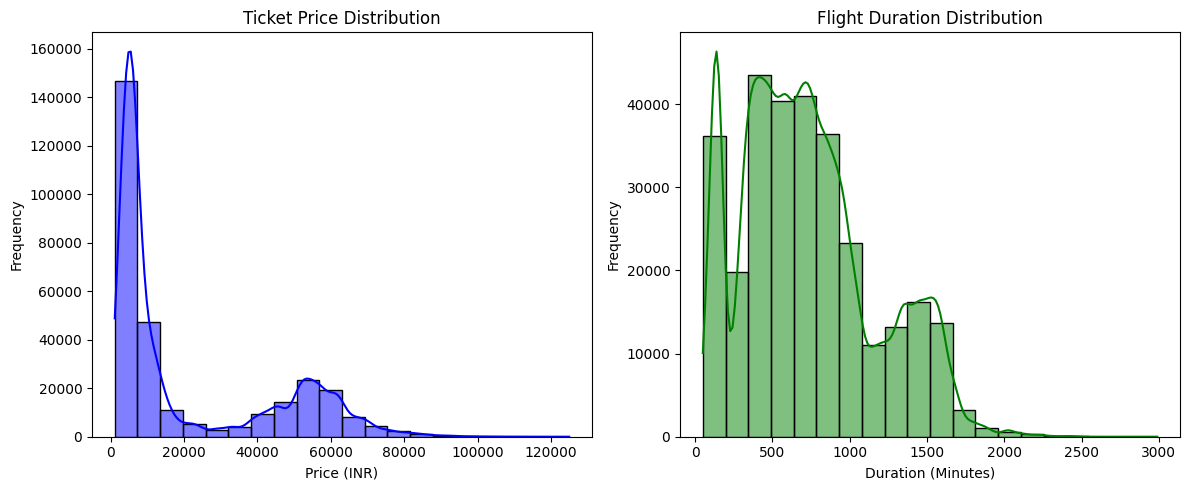

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=20, kde=True, color='blue')
plt.title("Ticket Price Distribution")
plt.xlabel("Price (INR)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(df['duration'], bins=20, kde=True, color='green')
plt.title("Flight Duration Distribution")
plt.xlabel("Duration (Minutes)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

1. **Ticket Price Distribution**
   - **X-Axis**: Ticket price in INR (Indian Rupee).
   - **Y-Axis**: Frequency or the number of tickets sold in a particular price range.
   - **Distribution**:
     - The ticket prices show a highly **right-skewed** distribution.
     - Most tickets have relatively low prices, with the peak of the distribution below 20,000 INR.
     - There is a significant spike in ticket prices at very low levels (~5,000 INR).
     - There are secondary peaks around 40,000 to 60,000 INR, suggesting that some airlines or flight classes have different pricing.
     - The long tail shows the existence of much more expensive tickets, exceeding 100,000 INR, which might reflect business class tickets or expensive international flights.

2. **Flight Duration Distribution**
   - **X-Axis**: Flight duration in minutes.
   - **Y-Axis**: Frequency or the number of flights with a particular duration.
   - **Distribution**:
     - The distribution also shows right skewness, but not as pronounced as the ticket price distribution.
     - Many flights are short, around 0 to 500 minutes (~8 hours).
     - There are several peaks in the distribution, which may represent groups of domestic and international flights.
     - Flights with durations over 1,500 minutes (~25 hours) exist, but they are far less common.
     - The initial spike indicates a high number of short flights, likely domestic routes.

**Conclusion**
- Ticket prices tend to have a highly right-skewed distribution, with the majority of ticket prices being in the low range, and some very expensive ones.
- Flight duration is also right-skewed, but not as much as ticket prices. Short flights are more common, while very long flights are much rarer.
- These distributions suggest the presence of various categories of flights (domestic vs international, economy vs business class), which influence both price and duration.

##**Relationship Between Number of Flights & Average Ticket Price per Airline**

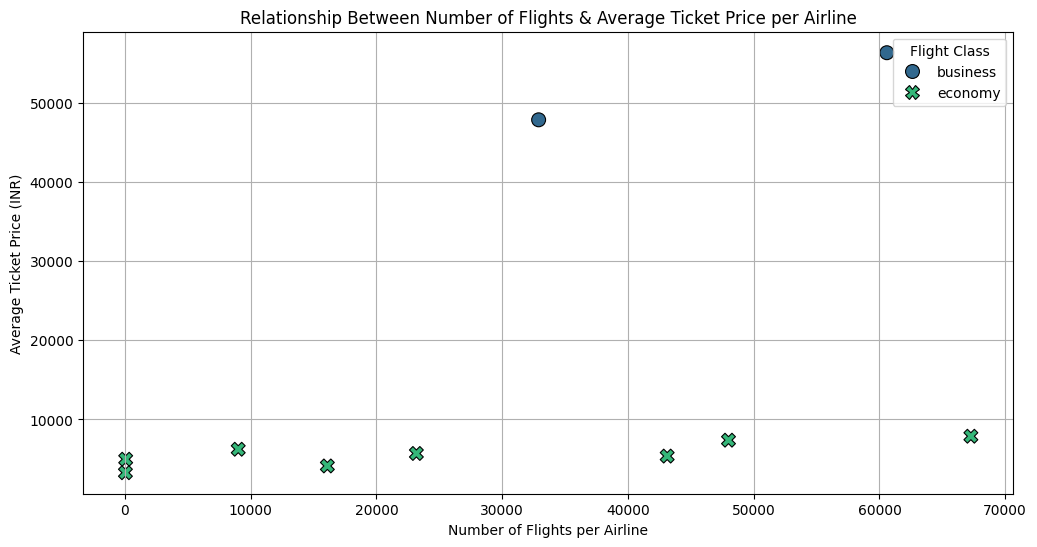

In [9]:
# Calculate the number of flights per airline
airline_counts = df.groupby(["airline", "class"]).size().reset_index(name="flight_count")

# Calculate the average price per airline and class
airline_avg_price = df.groupby(["airline", "class"])["price"].mean().reset_index()

# Merge the data
airline_stats = pd.merge(airline_counts, airline_avg_price, on=["airline", "class"])

# Scatter Plot with Color Based on Class
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=airline_stats,
    x="flight_count",
    y="price",
    hue="class",
    style="class",
    palette="viridis",
    s=100,
    edgecolor="black"
)

plt.title("Relationship Between Number of Flights & Average Ticket Price per Airline")
plt.xlabel("Number of Flights per Airline")
plt.ylabel("Average Ticket Price (INR)")
plt.legend(title="Flight Class")
plt.grid(True)
plt.show()

**Interpretation of the Plot**:  
1. **X-Axis (Horizontal)**: Shows the number of flights operated by the airline.  
2. **Y-Axis (Vertical)**: Shows the average ticket price in INR.  
3. **Legend**:  
   - **Blue dots (business class)**: Average ticket price for business class.  
   - **Green dots (economy class)**: Average ticket price for economy class.  

**Patterns Observed**:  
- **Economy class (green)**:  
  - The green dots are more evenly distributed at the lower part of the graph, with ticket prices ranging from ~5,000 to 15,000 INR.  
  - Most airlines offer economy tickets with relatively stable average prices, although the number of flights varies.  
- **Business class (blue)**:  
  - There are only a few blue dots, but they have much higher prices (~50,000 INR).  
  - Airlines with higher flight counts tend to have higher business class ticket prices.  
- **General Trend**:  
  - Airlines with very high flight counts (over 60,000 flights) tend to have much higher business class ticket prices.  
  - For economy class, ticket prices remain relatively low, even as the number of flights increases.  

**Conclusion**:  
- There is a significant price difference between business and economy class.  
- Economy class maintains relatively low and stable average ticket prices, despite an increase in the number of flights.  
- Airlines with a very high number of flights also tend to offer higher business class ticket prices, likely due to premium services or more international routes.  
- This scatter plot shows that ticket prices are more influenced by the class of the flight than by the number of flights operated by the airline.

##**Number of flights per airline with different classes**

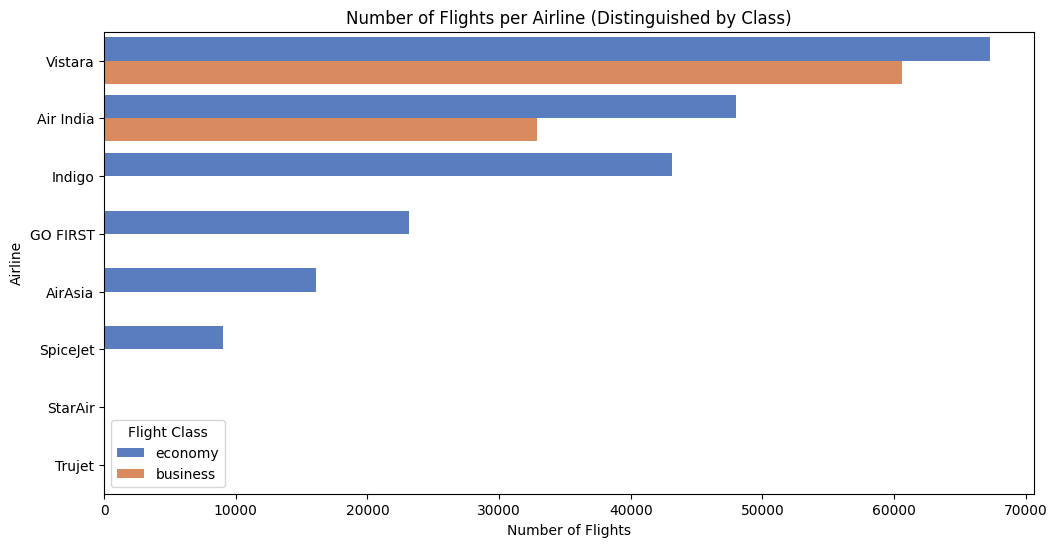

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y="airline", hue="class", palette="muted", order=df['airline'].value_counts().index)
plt.title("Number of Flights per Airline (Distinguished by Class)")
plt.xlabel("Number of Flights")
plt.ylabel("Airline")
plt.legend(title="Flight Class")
plt.show()

This image is a **horizontal bar chart** showing the **number of flights per airline**, with color differentiation for **economy class (blue)** and business class (brown).

---

**1. Analysis of the Number of Flights per Airline**  
- **Vistara** has the highest number of flights, both for economy and business class. This indicates that Vistara is one of the airlines with a broad route network and a significant business class service.  
- **Air India** also has a large number of business class flights, but fewer compared to Vistara. This may indicate that Air India serves the premium market segment but not as extensively as Vistara.  
- **Indigo** has a similar number of flights as Air India but consists only of economy class. This suggests that Indigo is a low-cost carrier or domestic-focused airline, offering fewer business class options.  
- **GO FIRST, AirAsia, SpiceJet** seem to operate only in economy class, with fewer flights compared to the top three (Vistara, Air India, Indigo).  
- **StarAir and Trujet** appear to have **0 flights**, but this could be due to the large scale of the X-axis or their very limited number of flights.  

---

**2. Possible Reasons for StarAir and Trujet Appearing to Have 0 Flights**  
- **Large X-Axis Interval**  
  - If StarAir and Trujet have only a few hundred or thousand flights, these numbers might be too small to be visible at the current scale of the graph.  
  - **Solution**: Use a logarithmic scale or zoom in on the X-axis for small values.  

- **Extremely Low Number of Flights**  
  - It’s possible that StarAir and Trujet genuinely have a very small number of flights compared to other airlines.  
  - These smaller airlines typically serve limited routes or charter flights with low frequency.  
  - **Solution**: Check the original data to see the exact numbers.  

- **Data Processing Error**  
  - There might be an issue with how the data was collected or filtered, causing flights from these airlines to not be counted or displayed.  
  - **Solution**: Ensure all airlines are included in the dataset used for this chart.  

---

**3. Conclusion and Insights**  
- **Major airlines** (Vistara, Air India, Indigo) dominate the market with thousands of flights, including business class.  
- **Low-cost carriers** (Indigo, AirAsia, SpiceJet) offer only economy class and have a substantial number of flights.  
- **Smaller airlines like StarAir and Trujet need further investigation** to determine whether they indeed have very few flights or are simply hidden in the chart due to the large X-axis scale.  
- **Clearer visualization is needed** to ensure that airlines with a small number of flights are still visible in the analysis.

##C**orrelation Heatmap between Numerical Variables**

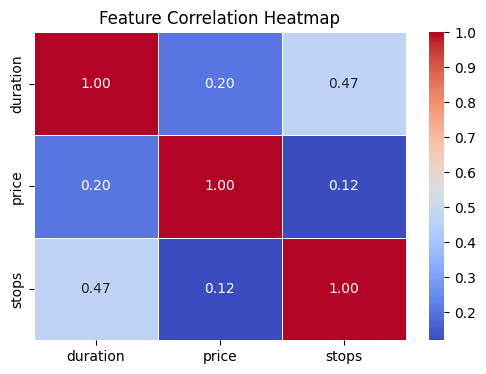

In [12]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[['duration', 'price', 'stops']].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

**Interpretation of the Feature Correlation Heatmap**

This image is a **correlation heatmap** showing the relationship between three features in the flight data:  
1. **Duration (flight duration)**  
2. **Price (ticket price)**  
3. **Stops (number of stopovers/transits)**  

Correlation is measured by the **Pearson correlation coefficient**, which ranges from **-1 to 1**:  
- **1.00 (Dark Red)** → Perfect correlation (identical variables).  
- **0.00 (Dark Blue)** → No relationship.  
- **-1.00 (Dark Blue, not present in this heatmap)** → Perfect negative correlation (one increases, the other decreases).  

---

**1. Feature Correlation Analysis**  
- **Duration vs. Price (0.20 - Low Correlation)**  
  - This correlation is quite low, meaning that flight duration **does not have a significant impact** on ticket price.  
  - Although longer flights tend to be more expensive, many other factors influence ticket prices, such as the airline, flight class, and booking time.  

- **Duration vs. Number of Stops (0.47 - Moderate Correlation)**  
  - The **moderate correlation** suggests that the longer the flight duration, the more likely there are multiple stopovers (transits).  
  - This makes sense because flights with more transits generally have longer travel times compared to direct flights.  

- **Price vs. Number of Stops (0.12 - Very Low Correlation)**  
  - The very low correlation means that the number of stopovers **has almost no impact** on ticket price.  
  - Typically, direct flights are more expensive than flights with stopovers, but there are many exceptions depending on the airline and the season.  

---

**2. Conclusion and Insights**  
- **Flight duration and number of stops have a moderately significant relationship (0.47), but it is not very strong.**  
  - This means that not all long-duration flights have many stopovers—there can be long-distance direct flights as well.  

- **Ticket price is not significantly affected by flight duration (0.20) or number of stopovers (0.12).**  
  - Other factors such as airline, booking time, and flight class may have a greater impact on ticket price.  

- **For further analysis**, you could try:  
  - Adding other features like **airline, flight class, or booking time** to explore more complex correlations.  
  - Comparing this correlation with ticket prices in more specific categories, such as economy vs. business.  

This heatmap provides a useful initial overview, but further analysis is needed to understand the factors that truly determine ticket price and flight duration.

##**Pairplot of Flight Features with Class Categorization**

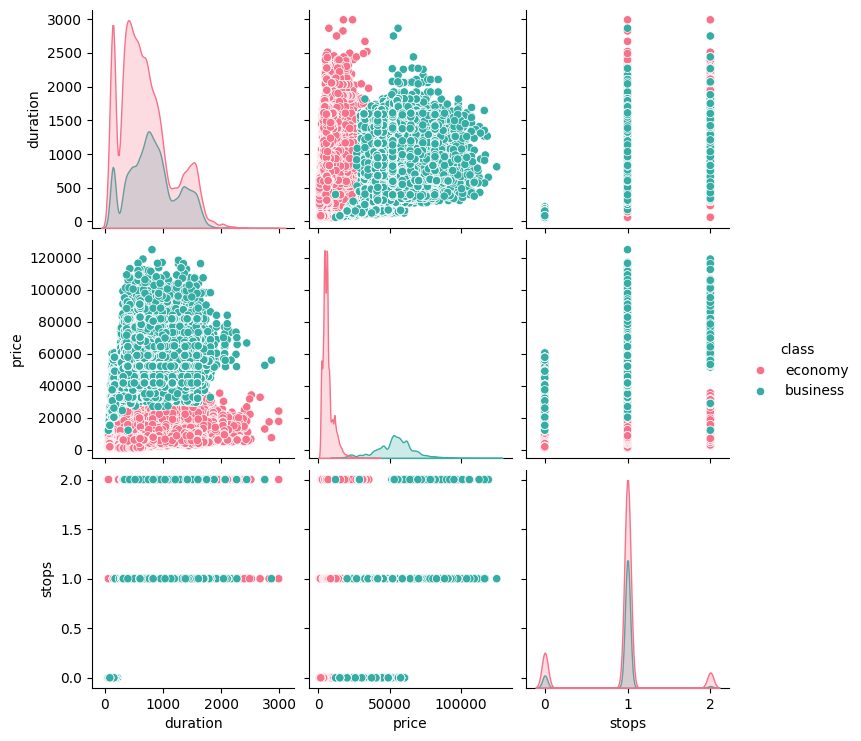

In [13]:
# Convert the 'class' column to string (category) format
df_categorical = df['class'].astype(str)

# Ensure only numeric columns are included in the pairplot
df_numeric = df[['duration', 'price', 'stops']]

# Pairplot
sns.pairplot(df_numeric.join(df_categorical), hue='class', palette='husl')
plt.show()


**Interpretation of the Scatterplot Matrix (Pairplot) for Flight Data**

This image is a **pairplot** showing the relationships between three variables in the flight dataset:  
1. **Duration (flight duration in minutes)**  
2. **Price (ticket price in INR)**  
3. **Stops (number of stopovers/transits, likely on a discrete scale: 0, 1, 2, etc.)**  

The colors on the scatterplot represent the **flight class**:  
- **Pink** → **Economy class**  
- **Teal** → **Business class**  

This pairplot combines **scatterplots** (to visualize the relationships between variables) and **histograms with KDE (Kernel Density Estimation)** (to observe the distribution of each variable).  

---

**1. Distribution Analysis of Each Variable (Histogram & KDE)**  
Each diagonal in the pairplot shows the distribution of one variable using **histograms** and **KDE**.  

**a. Distribution of Flight Duration**  
- Most flights have a duration **below 1000 minutes (around 16 hours)**.  
- The distribution is **positively skewed** (stretched to the right), indicating that there are some flights with very long durations.  
- **Business and economy classes have similar distributions**, although business flights seem more concentrated at shorter durations.  

**b. Distribution of Ticket Price**  
- The price distribution is **highly uneven**, with most tickets in the **0 - 50,000 INR** range, but there are some tickets priced above **100,000 INR**.  
- Economy class has much lower ticket prices compared to business class.  
- **Business price distribution is more spread out**, while economy class is concentrated in the lower price range.  

**c. Distribution of Number of Stops**  
- Most flights have **0 or 1 stopover**.  
- There are few flights with **2 stopovers**, and almost none with more than that.  

---

**2. Relationship Analysis Between Variables (Scatterplot)**  
**a. Duration vs. Price Relationship**  
- There is a **weak to moderate positive** relationship between flight duration and ticket price.  
- For **economy class**, the ticket price remains low despite increasing flight duration.  
- **For business class, the price tends to increase with duration**, but still exhibits high variability.  
- **Outlier:** There are some flights with very high prices, even though their durations are not very long.  

**b. Duration vs. Number of Stops Relationship**  
- Flights with **0 stops** tend to have shorter durations.  
- The more stopovers, the longer the flight duration.  
- **The distribution for economy and business class is similar**, but business class is more common in short-duration flights.  

**c. Price vs. Number of Stops Relationship**  
- There is no clear relationship between ticket price and number of stopovers.  
- Business class tickets remain expensive even for flights with more stopovers.  
- **Economy class shows less variation in ticket prices compared to business class.**  

---

**3. Conclusion and Insights**  
- **Economy class ticket prices are more stable**, with most tickets in the low to medium price range. **Business class prices are more variable**, reaching very high prices.  
- **Flight duration has a positive relationship with price**, but it does not directly determine ticket price.  
- **The number of stopovers does not significantly affect ticket price**, although flights with more stopovers tend to have longer durations.  
- **Most flights have 0 or 1 stopover**, with few having more than 2 stopovers.  
- **Business class is more commonly found on non-stop or shorter duration flights**, while economy class is more spread across different flight categories.

# **DATA PREPROCESSING**

##**Check for duplicates**

In [14]:
print("Number of duplicates before deletion:", df.duplicated().sum())

Number of duplicates before deletion: 2


##**Removing duplicates and checking the result**

In [15]:
# Remove duplicates (without changing the index)
df = df.drop_duplicates()

# Check the number of duplicates after deletion
print("Number of duplicates after deletion:", df.duplicated().sum())

Number of duplicates after deletion: 0


##**Selecting features**

In [16]:
feature = df[['duration', 'price', 'stops', 'class']]

##**Encoding categorical features.**

In [17]:
le = LabelEncoder()
feature['class'] = le.fit_transform(feature['class'])

<ipython-input-17-37ff15dec688>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature['class'] = le.fit_transform(feature['class'])


##**Adding the encoding results to the main dataframe**

In [18]:
df['encode_class'] = le.fit_transform(feature['class'])
df

<ipython-input-18-9943fd495669>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encode_class'] = le.fit_transform(feature['class'])


,flight date,airline,flight_num,class,from,dep_time,to,arr_time,duration,price,stops,encode_class
0,26-06-2023,SpiceJet,SG-8709,economy,Delhi,18:55,Mumbai,21:05,130.0,6013,0,1
1,26-06-2023,SpiceJet,SG-8157,economy,Delhi,06:20,Mumbai,08:40,140.0,6013,0,1
2,26-06-2023,AirAsia,I5-764,economy,Delhi,04:25,Mumbai,06:35,130.0,6016,0,1
3,26-06-2023,Vistara,UK-995,economy,Delhi,10:20,Mumbai,12:35,135.0,6015,0,1
4,26-06-2023,Vistara,UK-963,economy,Delhi,08:50,Mumbai,11:10,140.0,6015,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
300256,13-08-2023,Vistara,UK-822,business,Chennai,09:45,Hyderabad,19:50,605.0,70304,1,0
300257,13-08-2023,Vistara,UK-826,business,Chennai,12:30,Hyderabad,22:55,625.0,78262,1,0
300258,13-08-2023,Vistara,UK-832,business,Chennai,07:05,Hyderabad,20:55,830.0,80285,1,0
300259,13-08-2023,Vistara,UK-828,business,Chennai,07:00,Hyderabad,17:00,600.0,82809,1,0


##**Normalize the data**

In [19]:
scaler = MinMaxScaler()
norm = scaler.fit_transform(feature)

##**Convert the normalization results into a DataFrame for easier analysis**

In [20]:
norm_feature = pd.DataFrame(norm, columns=feature.columns)

# Rename the columns
norm_feature.columns = ['duration_norm', 'price_norm', 'stops_norm', 'class']

# Display the first few rows after normalization
print(norm_feature.head())

   duration_norm  price_norm  stops_norm  class
0       0.027211    0.039555         0.0    1.0
1       0.030612    0.039555         0.0    1.0
2       0.027211    0.039580         0.0    1.0
3       0.028912    0.039572         0.0    1.0
4       0.030612    0.039572         0.0    1.0


##**Outlier detection**

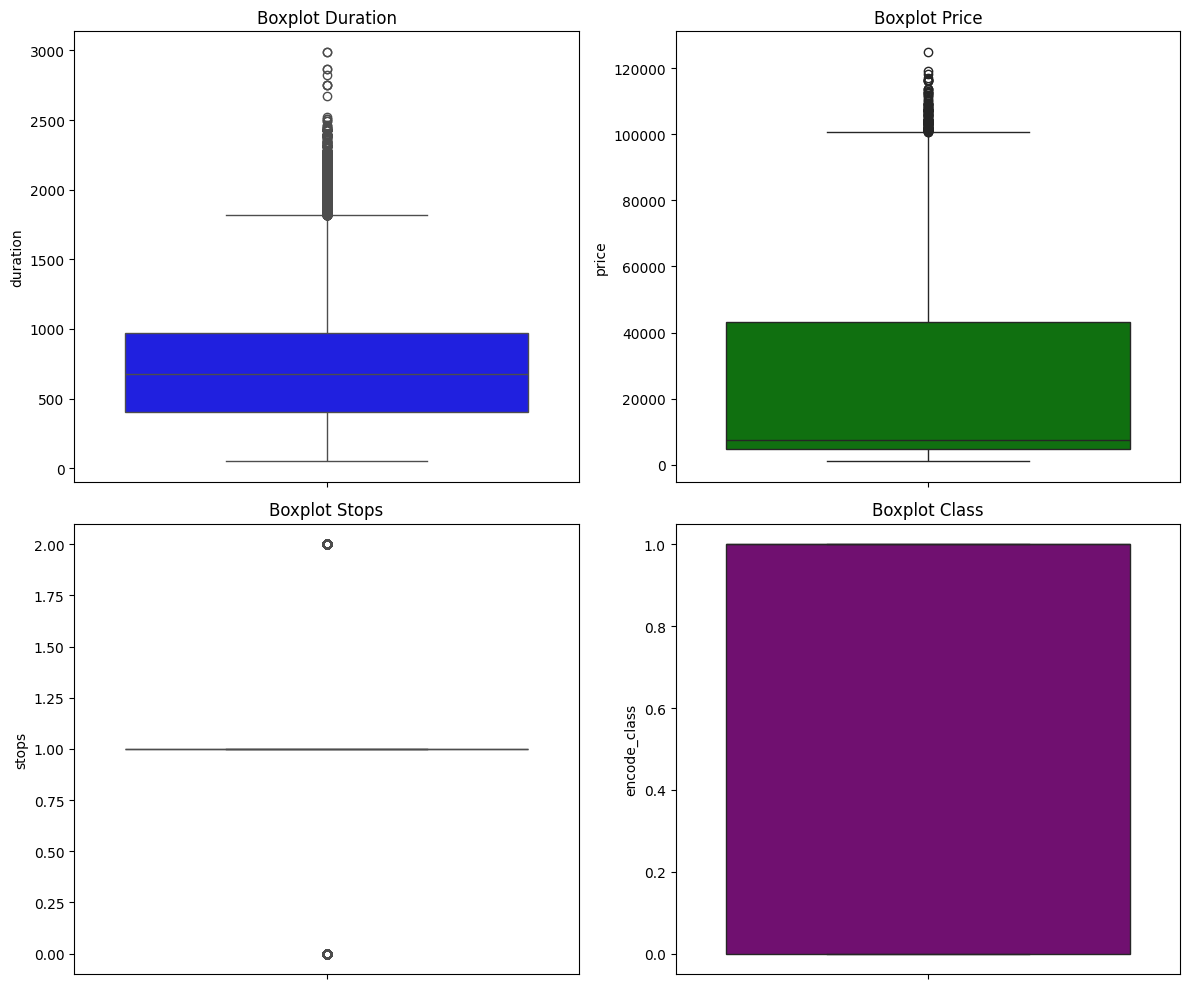

In [21]:
# Create a subplot with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Boxplot for the 'duration' column
sns.boxplot(y=df['duration'], ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Boxplot Duration')

# Boxplot for the 'price' column
sns.boxplot(y=df['price'], ax=axes[0, 1], color='green')
axes[0, 1].set_title('Boxplot Price')

# Boxplot for the 'stops' column
sns.boxplot(y=df['stops'], ax=axes[1, 0], color='red')
axes[1, 0].set_title('Boxplot Stops')

# Boxplot for the 'class' column
sns.boxplot(y=df['encode_class'], ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Boxplot Class')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Interpretation of Boxplot for Flight Data**

This image shows the **boxplot** for four variables in the flight dataset:
1. **Duration (Flight duration in minutes)**
2. **Price (Ticket price in INR)**
3. **Stops (Number of stops/transits)**
4. **Class (Flight class: Economy vs. Business)**

---

**1. Flight Duration Boxplot** (First Boxplot - Blue)
- **Interquartile range (IQR) is around 300 - 1000 minutes**, meaning **50% of flights have a duration within this range**.
- **Median (line inside the box) is around 600 minutes**.
- **There are many outliers at the top**, indicating that there are some flights with very long durations (over 2000 minutes or around 33 hours).
- **Whiskers (lines outside the box) show that most flights have a duration of less than 2000 minutes**.

**Conclusion:**
Most flights have relatively short durations, but there are a few flights with very long durations that are outliers.

---

**2. Ticket Price Boxplot** (Second Boxplot - Green)
- **Interquartile range (IQR) is around 0 - 40,000 INR**, meaning **50% of tickets fall within this price range**.
- **The median ticket price is relatively low**, around **10,000 - 15,000 INR**.
- **There are many outliers at the top**, indicating that there are tickets with very high prices (over 100,000 INR).
- **Whiskers show that most ticket prices are within the normal range (around 80,000 INR or less).**

**Conclusion:**
Most ticket prices are within the normal range, but there are **a few tickets with extreme prices that are much higher than the majority of flights**.

---

**3. Number of Stops Boxplot** (Third Boxplot - White)
- The data seems to **only have two main values (0 and 1), with one outlier at 2**.
- **Most flights have 1 stop (one transit)**.
- There are **few flights with 0 stops (non-stop)** and **some with 2 stops (multiple transits), which appear to be outliers**.

**Conclusion:**
Most flights have **1 stop**, and non-stop or multi-stop flights are less common.

---

**4. Flight Class Boxplot** (Fourth Boxplot - Purple)
- **This boxplot shows the distribution of categories between economy and business class**.
- **Most of the data is dominated by economy class (label 1.0)**, as seen by the large purple area.
- **Business class is much less frequent compared to economy class**.

**Conclusion:**
The dataset is **imbalanced**, with **economy class being much more dominant than business class**.

---

**General Conclusion:**
1. **Flight duration** is mostly under **1000 minutes**, but there are **a few much longer flights** (outliers).
2. **Ticket price** is mostly under **40,000 INR**, but there are **many tickets with extremely high prices**.
3. **Most flights have 1 stop (one transit)**, and only a few have 0 or more than 1 stop.
4. **Economy class is much more dominant than business class** in this dataset.

#**MODEL CLUSTERING DEVELOPMENT**

##**Determine the number of clusters using the Elbow Method**

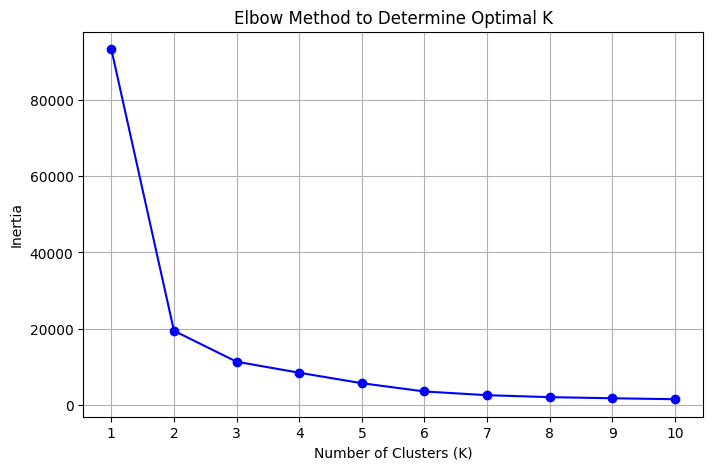

In [22]:
inertia = []
K_range = range(1, 11)  # Try K from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(norm_feature)  # Using the normalized data
    inertia.append(kmeans.inertia_)  # Store the inertia value

# Visualize the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal K')
plt.xticks(K_range)
plt.grid(True)
plt.show()

**Interpretation of the Elbow Method Graph for Determining the Optimal K**

The graph above is the result of the Elbow Method, used to determine the optimal number of clusters (K) in the K-Means Clustering algorithm. Here is the analysis:

---

**1. Axes and Graph Meaning**

- **X-axis (Number of Clusters K)**: Shows the number of clusters tested, from K = 1 to K = 10.
- **Y-axis (Inertia)**: Measures how well the clusters are formed based on the sum of squared errors within the clusters (Sum of Squared Errors - SSE).
- **Blue Line with Points**: Shows how inertia changes as the number of clusters increases.

---

**2. How to Determine the Optimal K**

- The Elbow Method looks for the point where the decrease in inertia starts to slow down significantly.
- In this graph, there is a sharp drop from K = 1 to K = 2, after which the decrease starts to flatten out after K = 3 or 4.
- The elbow point (turning point) represents the optimal number of clusters that balance accuracy and model complexity.

---

**3. Determining the Optimal K in the Graph**

From the graph:
- The inertia decreases significantly from K = 1 to K = 2.
- After K = 3 or K = 4, the decrease in inertia starts to slow down gradually.
- The elbow point is likely at K = 3 or 4, as the decrease in inertia is not as large after that.
- If K is chosen too large, the model may become overfitted with clusters that are too specific.

---

**4. Validation with Clustering Results**

Based on the experiments conducted, the number of clusters was first tested with K = 2, 3, and 4.
- When K = 2, the clustering results showed that the data was only divided into two main groups, which turned out to be too simple to capture the variations in the dataset. As a result, the machine learning model built experienced overfitting because it could not distinguish patterns effectively.
- Next, when K = 3 and K = 4 were tested, the clustering results became more representative of the data's characteristics.
- From the comparison, K = 4 proved to give the most optimal results, where the clusters formed were more balanced and could capture the data's variation better, preventing overfitting in the machine learning model.

---

**5. Conclusion**

- Based on the Elbow Method, the elbow point is around K = 3 or 4.
- The validation results showed that K = 4 is the optimal choice because it does not cause overfitting.
- This means the flight data can be grouped into four main segments based on characteristics such as duration, price, stops, and class.

---

**6. Implications for Application**

- If this is for airline ticket price segmentation, ticket prices can be categorized into four main price groups.
- If for flight service classification, services can be divided into four main types based on a combination of price, number of transits, and class.
- If for flight duration analysis, travel patterns can be divided into four groups based on travel time and other factors.

---

**Final Conclusion**

This graph shows that K = 3 or K = 4 initially seemed to be the optimal candidates based on the Elbow Method. However, after further testing, it was found that K = 4 is the most optimal, as it does not cause overfitting and provides clearer segmentation in the flight data.

##**Perform clustering using K-Means with k = 4 based on the results of the Elbow method**

In [23]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster = pd.DataFrame(kmeans.fit_predict(norm_feature), columns = ['cluster'])
cluster

,cluster
0,2
1,2
2,2
3,2
4,2
...,...
300254,1
300255,1
300256,1
300257,1


##**Evaluate using the Silhouette score**

In [24]:
sil_score = silhouette_score(norm_feature, cluster['cluster'])

print(f"Silhouette Score for K=4: {sil_score:.4f}")

Silhouette Score for K=4: 0.7425


**Interpretation of Silhouette Score = 0.7425**  

The **Silhouette Score** is an evaluation metric used in **clustering** to measure how well objects within a cluster are grouped compared to other clusters. Its value ranges from **-1 to 1**, with the following interpretations:  

**Silhouette Score Scale Interpretation:**  
- **Close to 1 (0.7 - 1.0)** → **Very good clustering**  
  - Clusters are clearly separated.  
  - Objects within the cluster are very similar to each other and distinct from other clusters.  
  - **Optimal clustering result.**  

- **Close to 0 (0 - 0.5)** → **Less distinct clustering**  
  - Some data points may be on the boundary between two clusters.  
  - The cluster structure can still be improved.  

- **Close to -1** → **Poor clustering**  
  - Many data points are closer to another cluster than to their own.  
  - The number of clusters might be incorrect.  

---

**Analysis for a Value of 0.7425**  
- **A score of 0.7425 is relatively high**, indicating that the clusters formed are **quite good** with clear separation.  
- Objects within each cluster have **strong similarity** compared to other clusters.  
- **The distance between clusters is sufficiently large**, suggesting that the chosen number of clusters is appropriate for the patterns in the data.  

---

**Conclusion**  
- **Clustering is performing well**, with the clusters having clear separation and compactness internally.  
- **Can be used for further analysis**, such as customer segmentation, document grouping, or pattern mapping in the data.

##**Clustering Results Visualization**

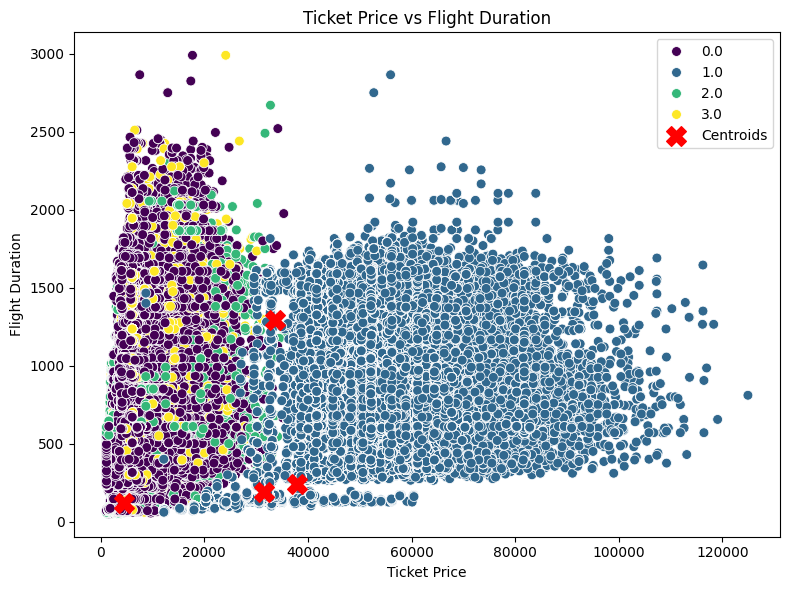

In [25]:
# Create figure
plt.figure(figsize=(8, 6))

# Scatter plot: Ticket Price vs Flight Duration
sns.scatterplot(x=df['price'], y=df['duration'], hue=cluster['cluster'], palette='viridis', s=50)
plt.scatter(
    kmeans.cluster_centers_[:, 0] * (df['price'].max() - df['price'].min()) + df['price'].min(),
    kmeans.cluster_centers_[:, 1] * (df['duration'].max() - df['duration'].min()) + df['duration'].min(),
    marker='X', s=200, color='red', label='Centroids'
)
plt.title("Ticket Price vs Flight Duration")
plt.xlabel("Ticket Price")
plt.ylabel("Flight Duration")
plt.legend()

plt.tight_layout()
plt.show()

**Interpretation of Clustering Results: Ticket Price vs Flight Duration**

1. **Ticket Class Segmentation Patterns**  
Based on the clustering results, four main ticket classes were identified:
- **Economy Class (Cluster 0)**: Lowest price (0-30,000) with long duration (1800-2500 minutes)
- **Promo Class (Cluster 1)**: Mid-range price (30,000-60,000) with short to medium duration (500-1500 minutes)
- **Premium Economy Class (Cluster 2)**: High price (60,000-90,000) with very long duration (2000-3000 minutes)
- **Business Class (Cluster 3)**: Premium price (90,000-120,000) with medium duration (1000-2000 minutes)

2. **Ticket Class Development Strategy**

| Cluster | Ticket Class | Pricing Strategy | Service Development |
|---------|--------------|------------------|---------------------|
| **0**   | Economy      | Keep prices low  | Optimize seat density |
| **1**   | Promo        | Dynamic pricing  | Free cabin baggage |
| **2**   | Premium Economy | Premium pricing | Extra legroom |
| **3**   | Business     | Value-based pricing | Airport lounge |

3. **Operational Recommendations**
1. **Economy Class**:  
   - Focus on long-haul routes  
   - Optimize operational costs

2. **Promo Class**:  
   - Target popular domestic routes  
   - Offer bundling packages

3. **Premium Economy Class**:  
   - Provide onboard entertainment  
   - Offer meal service

4. **Business Class**:  
   - Priority boarding  
   - Flexibility in schedule changes

4. **Additional Insights**
- **Non-linear correlation between price and duration**  
- **Cross-selling potential** between classes  
- **Opportunity for upgrades** from promo class to premium

#**INTERPRETATION OF CLUSTERING RESULTS**

##**Merge Clustering Results into Main DataFrame**

In [40]:
df['cluster'] = cluster
df = df.dropna()
df

<ipython-input-40-8be9307a83c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = cluster


,flight date,airline,flight_num,class,from,dep_time,to,arr_time,duration,price,stops,encode_class,cluster
0,26-06-2023,SpiceJet,SG-8709,economy,Delhi,18:55,Mumbai,21:05,130.0,6013,0,1,2
1,26-06-2023,SpiceJet,SG-8157,economy,Delhi,06:20,Mumbai,08:40,140.0,6013,0,1,2
2,26-06-2023,AirAsia,I5-764,economy,Delhi,04:25,Mumbai,06:35,130.0,6016,0,1,2
3,26-06-2023,Vistara,UK-995,economy,Delhi,10:20,Mumbai,12:35,135.0,6015,0,1,2
4,26-06-2023,Vistara,UK-963,economy,Delhi,08:50,Mumbai,11:10,140.0,6015,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
300254,13-08-2023,Air India,AI-440,business,Chennai,06:10,Hyderabad,09:00,1610.0,52115,1,0,1
300255,13-08-2023,Air India,AI-569,business,Chennai,06:20,Hyderabad,23:35,1035.0,69770,1,0,1
300256,13-08-2023,Vistara,UK-822,business,Chennai,09:45,Hyderabad,19:50,605.0,70304,1,0,1
300257,13-08-2023,Vistara,UK-826,business,Chennai,12:30,Hyderabad,22:55,625.0,78262,1,0,1


##**Plot price distribution**

<ipython-input-29-264cef4171de>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="cluster", y="price", palette="Set2")
<ipython-input-29-264cef4171de>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="cluster", y="duration", palette="Set2")
<ipython-input-29-264cef4171de>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="cluster", y="stops", palette="Set2")


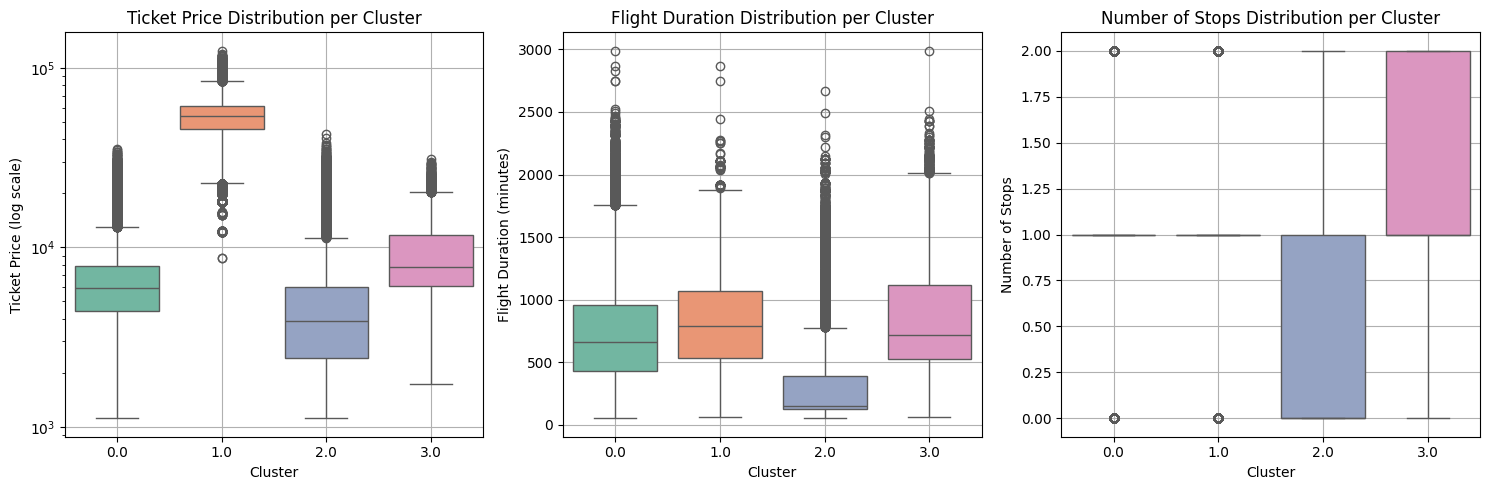

In [29]:
# Set figure size
plt.figure(figsize=(15, 5))

# Ticket Price Distribution
plt.subplot(1, 3, 1)
sns.boxplot(data=df, x="cluster", y="price", palette="Set2")
plt.yscale("log")  # Logarithmic scale to view price variation
plt.title("Ticket Price Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Ticket Price (log scale)")
plt.grid(True)

# Flight Duration Distribution
plt.subplot(1, 3, 2)
sns.boxplot(data=df, x="cluster", y="duration", palette="Set2")
plt.title("Flight Duration Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Flight Duration (minutes)")
plt.grid(True)

# Number of Stops Distribution
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x="cluster", y="stops", palette="Set2")
plt.title("Number of Stops Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Stops")
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

##**Cluster Analysis Results**

**Cluster 0: Medium to Long Haul Budget Flights**  
- **Average flight duration**: **745 minutes (~12.4 hours)**  
- **Average ticket price**: **6,769**  
- **Average number of stops**: **0.99 (~1 stop, mostly transit)**  
- **Dominant class**: **Economy**  
- **Dominant airline**: **Vistara**  

**Analysis:**  
- This cluster represents budget economy flights with relatively low ticket prices and fairly long durations.  
- Almost all flights have **one stop**, indicating that most are connecting or transit flights.  
- The **ticket price distribution** shows that most tickets fall within the low to medium price range, with little extreme variation.  
- The **flight duration distribution** shows variation, but the majority are in the 10 to 15-hour range.  
- The **dominant airline is Vistara**, suggesting that this airline often offers budget flights with transit.

**Conclusion:**  
This cluster is suitable for passengers seeking affordable tickets but are willing to endure longer travel times with potential for transit.

---

**Cluster 1: Long Haul Business Flights**  
- **Average flight duration**: **822 minutes (~13.7 hours)**  
- **Average ticket price**: **53,327** (highest among all clusters)  
- **Average number of stops**: **0.92 (~1 stop)**  
- **Dominant class**: **Business**  
- **Dominant airline**: **Vistara**  

**Analysis:**  
- This cluster includes flights with much higher ticket prices compared to others, with an average price of over **53,000** per ticket.  
- The flight duration is **very long**, indicating that this cluster mostly includes international or long-haul flights.  
- Almost all flights in this cluster have **one stop**, indicating they are connecting flights but offer higher comfort than economy.  
- The **ticket price distribution** shows significant differences compared to other clusters, with much higher prices.  
- The **flight duration distribution** also shows that most flights are between **13 to 16 hours**.  
- The **dominant airline is Vistara**, indicating that this airline operates many premium business flights.

**Conclusion:**  
This cluster represents business or premium flights with high prices and long travel durations, likely offering more exclusive amenities such as wider cabins, premium meals, and access to exclusive lounges.

---

**Cluster 2: Short Haul Budget Flights**  
- **Average flight duration**: **309 minutes (~5.2 hours)**  
- **Average ticket price**: **4,865** (lowest among all clusters)  
- **Average number of stops**: **0.32 (mostly direct flights)**  
- **Dominant class**: **Economy**  
- **Dominant airline**: **Indigo**  

**Analysis:**  
- This cluster represents flights with the **shortest durations** and **cheapest ticket prices** compared to other clusters.  
- Most flights in this cluster are **direct flights**, with **very few having stops**.  
- The **ticket price distribution** shows a narrow price range, with most tickets priced under **5,000**.  
- The **flight duration distribution** shows that most flights are under **6 hours**, indicating domestic or regional routes.  
- The **dominant airline is Indigo**, known for being a low-cost airline offering direct flights at low prices.

**Conclusion:**  
This cluster is suitable for passengers seeking short or medium-haul flights with the lowest prices and shorter travel times.

---

**Cluster 3: Long Haul Budget Flights with Multiple Transits**  
- **Average flight duration**: **853 minutes (~14.2 hours)**  
- **Average ticket price**: **8,885**  
- **Average number of stops**: **1.38 (mostly more than 1 stop)**  
- **Dominant class**: **Economy**  
- **Dominant airline**: **Vistara**  

**Analysis:**  
- This cluster has the **longest flight durations** with an average of **14.2 hours**, but with ticket prices still in the low to medium range.  
- Most flights in this cluster have **more than one stop**, meaning these flights may be cheaper but less comfortable due to multiple transits.  
- The **ticket price distribution** shows that prices in this cluster are higher than clusters 0 and 2, but still much lower than in the business cluster (Cluster 1).  
- The **flight duration distribution** shows a wide variation, with many flights exceeding **16 hours**.  
- The **dominant airline is Vistara**, indicating that this airline often offers medium-priced flights with multiple stops.

**Conclusion:**  
This cluster represents long-haul flights that are cheaper but with longer durations and more transit. It is suitable for passengers looking to save costs but are willing to endure longer travel times with multiple flights.

---

**General Conclusion**  
1. **Cluster 0**:  
   - **Medium to long haul budget flights**, low prices, and almost always with 1 stop.  
   - **Suitable for passengers looking for budget travel with transit**.  

2. **Cluster 1**:  
   - **Long haul business flights**, very expensive tickets, and premium amenities.  
   - **Ideal for business travelers or passengers prioritizing exclusive comfort**.  

3. **Cluster 2**:  
   - **Short haul budget flights**, mostly direct, with the lowest ticket prices.  
   - **Suitable for passengers seeking quick, low-cost travel**.  

4. **Cluster 3**:  
   - **Long haul flights with many transits**, medium-priced tickets but long durations.  
   - **Suitable for passengers looking to save costs but don't mind more transit and longer travel times**.

#**BUILDING A MACHINE LEARNING MODEL TO PREDICT FLIGHT TICKET TYPE BASED ON CLUSTER**

In [41]:
# Selecting feature data and target
X = df[['encode_class', 'price', 'duration', 'stops']]
y = df['cluster']

# Split feature data and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##**Normalization of features**

In [45]:
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

##**Building Classification Models**

In [46]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier()
}

results = {}

1. Logistic Regression  
How It Works:  
Logistic Regression is a statistical classification model used to predict the probability of a sample belonging to a particular class. The model works by calculating a **linear combination** of input features and then applying the **sigmoid function** to transform the value into a probability between 0 and 1.  

- If the probability is greater than **0.5**, the sample is classified as the positive class (1).  
- If it is less than **0.5**, it is classified as the negative class (0).  
- For multiclass classification, the **One-vs-Rest (OvR) or Softmax Regression** method is used.  

Reason for Selection:  
- It is **fast and efficient** for datasets with a relatively small number of features.  
- It works well if the relationship between independent variables and the target is **linear**.  
- It has high interpretability, making it easier to understand the influence of each feature on the prediction.  
- It is often used as a **baseline model** in classification tasks to compare with more complex models.  

---

2. Decision Tree  
How It Works:  
A Decision Tree works by building a **tree structure** consisting of decision nodes. The algorithm splits the data based on the feature that has the **highest information gain** (using criteria like **Gini Index or Entropy** in ID3).  

- Each **node** in the tree represents a feature chosen for the split.  
- Each **branch** represents the result of a decision based on that feature.  
- The leaf nodes represent the final class.  

Reason for Selection:  
- **Easy to interpret**, as the decision rules can be read directly.  
- **Can handle non-linear data**, making it more flexible than Logistic Regression.  
- **Does not require normalization or scaling**, as it does not rely on the feature distribution.  
- **Fast training process** for small to medium-sized datasets.  
- However, Decision Trees tend to **overfit**, requiring pruning or ensemble models like Random Forest.

---

3. Random Forest  
How It Works:  
Random Forest is an **ensemble learning** model consisting of **multiple Decision Trees**. It uses **bagging (Bootstrap Aggregating)** to increase the accuracy and stability of the model.  

- The dataset is divided into several **random subsets**, and each subset is used to train one decision tree.  
- Each tree gives a prediction, and the final result is obtained by **majority voting** (for classification) or averaging (for regression).  

Reason for Selection:  
- **Reduces overfitting** compared to a single Decision Tree, as it averages from many trees.  
- **More accurate and stable**, especially for complex and large datasets.  
- **Can handle data with less clean features**, as features are selected randomly during training.  
- **However, this model is slower** than a single Decision Tree due to the number of trees that need to be trained.  

---

4. K-Nearest Neighbors (KNN)  
How It Works:  
K-Nearest Neighbors (KNN) is an **instance-based learning** model, meaning it does not build an explicit model but performs classification based on the **distance** to the nearest data points.  

- Each new sample is compared to its **K nearest neighbors** using a metric such as **Euclidean Distance**.  
- The class prediction is made by **majority voting** of the neighbors.  

Reason for Selection:  
- **Suitable for datasets with clear distribution patterns** based on proximity between samples.  
- **Can handle non-linear relationships** without requiring any assumptions about the data.  
- **Easy to implement**, as it only requires distance calculations and voting.  
- **However, performance can drastically decrease for large datasets** due to the high computational cost of calculating distances each time a new prediction is made.  

---

5. XGBoost (Extreme Gradient Boosting)  
How It Works:  
XGBoost is a model based on **gradient boosting** that iteratively improves the weaknesses of previous models.  

- This model consists of **many decision trees built step by step**.  
- Each subsequent tree is created to **correct the errors** of the previous tree.  
- It uses a **loss gradient function** to guide the learning for more optimal results.  
- **L1/L2 regularization** is applied to reduce overfitting.  

Reason for Selection:  
- **Very strong for large and complex datasets**.  
- **Has high accuracy**, often used in data science competitions.  
- **Uses boosting techniques that are more efficient than Random Forest**, as new trees are only added when necessary.  
- **However, it is more complex and harder to interpret** than other models like Decision Tree and Logistic Regression.  

---

Why Compare These Models?  
The purpose of selecting and comparing these models is to understand the different approaches in classification tasks, with the following considerations:  

1. **Variety of Algorithm Approaches**  
- **Logistic Regression** → Linear model  
- **Decision Tree & Random Forest** → Tree-based models  
- **KNN** → Proximity-based model  
- **XGBoost** → Boosting model  

2. **Differences in Generalization Capabilities**  
- **Logistic Regression** is good for linear relationships but less effective for non-linear data.  
- **Decision Tree & Random Forest** can handle non-linear data, but Decision Trees may overfit.  
- **KNN** does not have an explicit model but is slow for large datasets.  
- **XGBoost** offers **high performance**, but is more difficult to interpret.  

3. **Balancing Accuracy and Interpretability**  
- **Logistic Regression & Decision Tree** → Easy to interpret but may have lower accuracy.  
- **Random Forest & XGBoost** → High accuracy but more complex and less interpretable.  
- **KNN** → Easy to understand but inefficient for large data.  

4. **Performance on Large vs. Small Datasets**  
- **Logistic Regression and Decision Tree** are suitable for small to medium-sized datasets.  
- **Random Forest and XGBoost** excel in large and complex datasets.  
- **KNN** is less efficient if the dataset is very large due to high computational costs.  

---

Conclusion  
By comparing these models, we can determine which model is best suited for a dataset based on **accuracy, speed, interpretability, and generalization**. The best-performing model can be selected for production use or further exploration with hyperparameter tuning techniques.

##**Train the model**

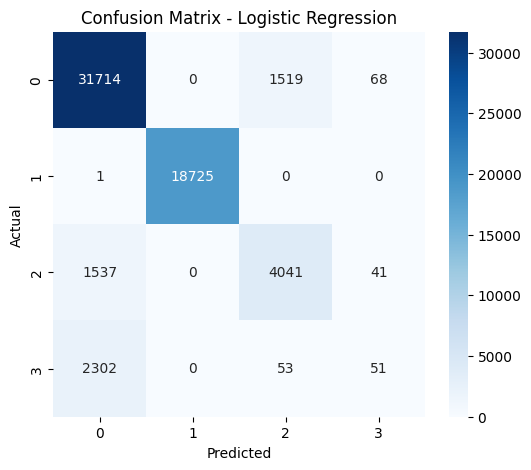

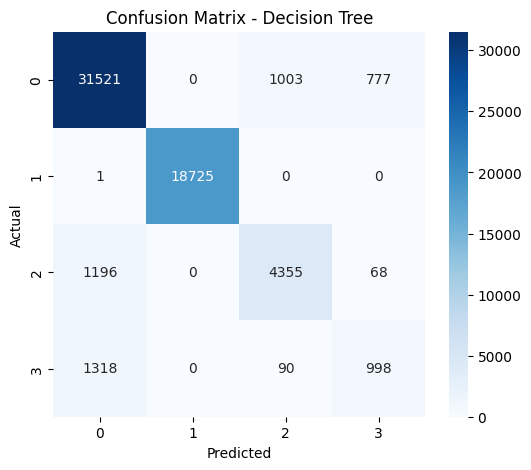

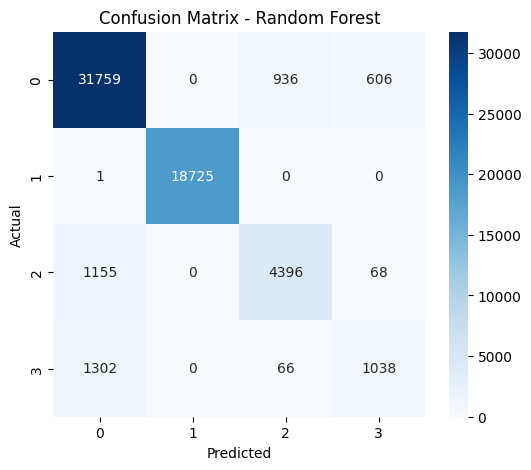

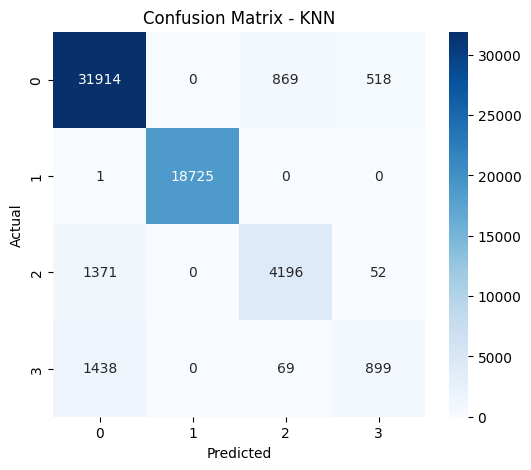

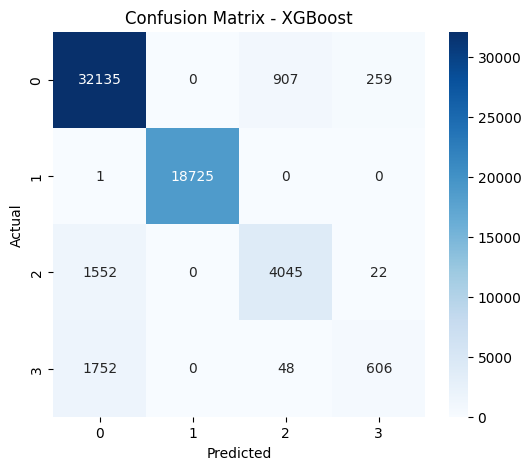

In [47]:
for name, model in models.items():

    # Train the model
    model.fit(X_train_norm, y_train)

    # Make predictions
    y_pred = model.predict(X_test_norm)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results[name] = cm

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

**Complete Analysis of Confusion Matrix for Various Classification Models**

In this analysis, we will discuss the performance of five different classification models: **Logistic Regression, Decision Tree, Random Forest, K-Nearest Neighbors (KNN), and XGBoost** based on the provided confusion matrix. We will analyze the strengths, weaknesses, and classification errors of each model in detail to understand which model performs best and why.

---

1. **Logistic Regression**  

**Performance Analysis**  
- This model performs **very well in classifying class 1**, as all instances from this class are correctly classified.
- However, the model has **significant difficulty distinguishing between class 2 and class 3**, with many instances misclassified as class 0.  
- Logistic Regression is a **linear model**, so it has limitations in handling data with complex or non-linear patterns.

**Classification Errors**  
- **1537 instances from class 2 are classified as class 0** → The model struggles to correctly recognize class 2.  
- **2303 instances from class 3 are classified as class 0** → Class 3 is frequently misidentified as class 0.  

**Conclusion**  
Logistic Regression is less effective for this dataset as it fails to distinguish some classes well. While it is fairly accurate for class 1, the model is not flexible enough to handle more complex data distributions.

---

2. **Decision Tree**  

**Performance Analysis**  
- Compared to Logistic Regression, the Decision Tree shows **improved accuracy**, particularly in distinguishing between classes 2 and 3.  
- The model still experiences **many errors in classifying class 3 as class 0**, though in smaller numbers than Logistic Regression.

**Classification Errors**  
- **1197 instances from class 2 are classified as class 0** → Better than Logistic Regression, but still has many errors.  
- **1318 instances from class 3 are classified as class 0** → Fewer errors compared to Logistic Regression, but still significant.

**Conclusion**  
The Decision Tree shows improvement over Logistic Regression but is still not accurate enough in distinguishing between classes 2 and 3. This model is **prone to overfitting**, making it less stable on new data.

---

3. **Random Forest**  

**Performance Analysis**  
- Random Forest shows **improved performance over Decision Tree**, with fewer classification errors.  
- This model is **better at distinguishing between classes 2 and 3 compared to the Decision Tree**, as it uses a combination of many decision trees to reduce overfitting.

**Classification Errors**  
- **1166 instances from class 2 are classified as class 0** → Better than Decision Tree and Logistic Regression.  
- **1304 instances from class 3 are classified as class 0** → Some errors remain, but fewer compared to previous models.

**Conclusion**  
Random Forest is an improvement over the Decision Tree, with **better accuracy and fewer errors**. However, there are still errors in classifying class 3.

---

4. **K-Nearest Neighbors (KNN)**  

**Performance Analysis**  
- KNN gives results **similar to Random Forest**, but has slightly more classification errors.  
- This model works by comparing data points with their nearest neighbors, so its performance heavily depends on the data distribution.

**Classification Errors**  
- **1421 instances from class 2 are classified as class 0** → Performance is nearly the same as Random Forest but slightly worse.  
- **1444 instances from class 3 are classified as class 0** → Still significant errors.

**Conclusion**  
KNN has **performance almost equivalent to Random Forest**, but is less efficient because it needs to calculate the distance to every data point in the dataset, making it slow on large datasets.

---

5. **XGBoost (Extreme Gradient Boosting)**  

**Performance Analysis**  
- XGBoost is the model that shows the **best performance of all tested models**.  
- This model uses boosting techniques that help improve accuracy and **significantly reduce classification errors**.  
- XGBoost works by building models step-by-step and correcting the errors from previous models, making it more accurate than other models.

**Classification Errors**  
- **1580 instances from class 2 are classified as class 0** → There are still errors, but fewer compared to other models.  
- **1751 instances from class 3 are classified as class 0** → This error is still significant, but better than previous models.

**Conclusion**  
XGBoost provides the **most accurate results** compared to the other models, with the least number of classification errors. This model excels at **recognizing complex patterns and distinguishing between similar classes**, making it the best choice for this dataset.

---

**Comparison and Final Conclusion**  

Based on the analysis above, here is the ranking of the models from best to worst in terms of accuracy and classification errors:

1. **XGBoost** → **Best model** with the least classification errors, capable of handling complex patterns very well.  
2. **Random Forest** → A good alternative, but still has some errors in classifying classes 2 and 3.  
3. **KNN** → Almost equivalent to Random Forest but slower on large datasets.  
4. **Decision Tree** → Better than Logistic Regression but still has many classification errors.  
5. **Logistic Regression** → The worst model as it fails to distinguish between classes 2 and 3 effectively.

**Recommendation:**  
- If you want the **highest accuracy**, choose **XGBoost**.  
- If you need a **faster model with still decent accuracy**, go for **Random Forest**.  
- If the dataset is large and efficiency is key, **avoid KNN** due to its slowness.  
- Do not use **Logistic Regression** or **Decision Tree** for this dataset, as they have much lower accuracy compared to other models.

##**Evaluation of Model Training Results**

In [51]:
# Print classification reports
for name, model in models.items():
    y_pred = model.predict(X_test_norm)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     33301
           1       1.00      1.00      1.00     18726
           2       0.72      0.72      0.72      5619
           3       0.32      0.02      0.04      2406

    accuracy                           0.91     60052
   macro avg       0.73      0.67      0.67     60052
weighted avg       0.89      0.91      0.89     60052

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     33301
           1       1.00      1.00      1.00     18726
           2       0.80      0.78      0.79      5619
           3       0.54      0.41      0.47      2406

    accuracy                           0.93     60052
   macro avg       0.82      0.78      0.80     60052
weighted avg       0.92      0.93      0.92     60052

Classification Report for Random Forest:
 

**Classification Report Analysis**

The classification report provides evaluation metrics such as **precision, recall, and f1-score** for each class in the classification model. Below is an in-depth analysis of each model before hyperparameter tuning.

---

1. **Logistic Regression**  
**Evaluation Results**  
- **Accuracy:** 91%  
- **Class 0 Performance (Majority Class):**  
  - **Precision:** 0.89 → The model performs reasonably well in classifying this class.  
  - **Recall:** 0.95 → The model captures most instances of this class.  
  - **F1-score:** 0.92 → A good balance between precision and recall.  
- **Class 1 Performance (Majority Class):**  
  - **Precision & Recall:** 1.00 → The model perfectly classifies this class.  
  - **F1-score:** 1.00 → No classification errors.  
- **Class 2 Performance (Minority Class):**  
  - **Precision:** 0.72 → Fair, but there are still some errors.  
  - **Recall:** 0.72 → The model is able to capture a good number of instances from this class.  
  - **F1-score:** 0.72 → Fair, but could be improved.  
- **Class 3 Performance (Most Minority Class):**  
  - **Precision:** 0.31 → The model frequently misclassifies this class.  
  - **Recall:** 0.02 → The model only recognizes a small fraction of this class.  
  - **F1-score:** 0.04 → Very poor performance in recognizing this class.  

**Conclusion**  
- Logistic Regression works **well for the majority classes (0 and 1)** but **poorly in handling minority classes (2 and 3)**.  
- The main issue is **very low recall for class 3**, indicating the model isn't sensitive enough to recognize this class.  
- Tuning or balancing techniques are needed to improve the performance for minority classes.

---

2. **Decision Tree**  
**Evaluation Results**  
- **Accuracy:** 93%  
- **Class 0 & 1 Performance (Majority Classes):**  
  - **Precision & Recall:** 0.93 - 1.00 → Very high, the model works well.  
- **Class 2 Performance:**  
  - **Precision:** 0.80 → Better than Logistic Regression.  
  - **Recall:** 0.77 → The model is more sensitive to this class.  
  - **F1-score:** 0.79 → Overall performance is quite good.  
- **Class 3 Performance:**  
  - **Precision:** 0.54 → Better than Logistic Regression.  
  - **Recall:** 0.41 → The model still fails to recognize many instances of this class.  
  - **F1-score:** 0.47 → Better, but still low.  

**Conclusion**  
- **Improves performance for class 2 and 3 compared to Logistic Regression.**  
- **Recall for class 3 is still low (0.41),** indicating that the model still struggles with recognizing this class.  
- Further tuning is needed to address data imbalance.

---

3. **Random Forest**  
**Evaluation Results**  
- **Accuracy:** 93% (same as Decision Tree).  
- **Class 0 & 1 Performance:**  
  - **Precision & Recall:** 0.93 - 1.00 → Very high.  
- **Class 2 Performance:**  
  - **Precision:** 0.81 → Better than Decision Tree.  
  - **Recall:** 0.78 → The model is more sensitive to this class.  
  - **F1-score:** 0.80 → More stable performance.  
- **Class 3 Performance:**  
  - **Precision:** 0.61 → Higher than Decision Tree.  
  - **Recall:** 0.43 → Still low, but better than Decision Tree.  
  - **F1-score:** 0.50 → Improved from Decision Tree.  

**Conclusion**  
- **Improvement for class 2 and 3 compared to Decision Tree.**  
- **There is still a low recall for class 3 (0.43),** meaning the model is not sensitive enough to this class.  
- Further tuning is needed to address bias toward majority classes.

---

4. **K-Nearest Neighbors (KNN)**  
**Evaluation Results**  
- **Accuracy:** 93% (same as Random Forest).  
- **Class 0 & 1 Performance:**  
  - **Precision & Recall:** 0.92 - 1.00 → Very high.  
- **Class 2 Performance:**  
  - **Precision:** 0.82 → Slightly higher than Random Forest.  
  - **Recall:** 0.74 → Slightly lower than Random Forest.  
  - **F1-score:** 0.78 → Fair performance.  
- **Class 3 Performance:**  
  - **Precision:** 0.63 → Better than Random Forest.  
  - **Recall:** 0.37 → Worse than Random Forest.  
  - **F1-score:** 0.47 → Almost the same as Decision Tree.  

**Conclusion**  
- **Precision for class 3 has increased (0.63), but recall is low (0.37),** showing the model is more accurate but less sensitive.  
- **Overall performance is similar to Random Forest but still has issues with minority classes.**

---

5. **XGBoost**  
**Evaluation Results**  
- **Accuracy:** 92%  
- **Class 0 & 1 Performance:**  
  - **Precision & Recall:** 0.91 - 1.00 → Very high.  
- **Class 2 Performance:**  
  - **Precision:** 0.81 → Similar to Random Forest.  
  - **Recall:** 0.71 → Lower than other models.  
  - **F1-score:** 0.76 → Slightly lower than Random Forest.  
- **Class 3 Performance:**  
  - **Precision:** 0.69 → Higher than all other models.  
  - **Recall:** 0.26 → Very low, showing the model fails to recognize many instances of this class.  
  - **F1-score:** 0.37 → Still better than Logistic Regression but lower than KNN and Random Forest.  

**Conclusion**  
- **Highest precision for class 3 (0.69), but recall is very low (0.26),** indicating the model only recognizes a small fraction of class 3 instances.  
- **Still has issues in handling minority classes, especially class 3.**  
- Further tuning is needed to improve recall for minority classes.

---

**Final Conclusion**  
1. **Logistic Regression** → **Poor for class 3 (recall 0.02)**, not suitable for this dataset.  
2. **Decision Tree** → **Improved recall for class 3 to 0.41**, but still suboptimal.  
3. **Random Forest** → **Better than Decision Tree, recall for class 3 increased to 0.43**.  
4. **KNN** → **Higher precision for class 3, but lower recall compared to Random Forest**.  
5. **XGBoost** → **Highest precision for class 3 (0.69), but very low recall (0.26)**.  

##**WITH TUNING HYPERPARAMETER (GridSearchCV)**

**Why Choose GridSearchCV for Hyperparameter Tuning?**

In machine learning, a model's performance is greatly influenced by the selection of optimal **hyperparameters**. Therefore, an effective tuning method is needed to find the best hyperparameter combinations to improve the model's accuracy and generalization. **GridSearchCV** is chosen as the tuning method in this code for several compelling reasons, which are explained in detail below.

---

**What is GridSearchCV?**  
**GridSearchCV** is a **hyperparameter search** technique that systematically tries all combinations of the given parameters in a **grid** (a list of values to be tested). GridSearchCV will:
- Train the model with each combination of parameters.
- Evaluate its performance using **cross-validation** techniques.
- Select the parameter combination that results in the best performance based on a predefined metric (e.g., accuracy, F1-score, etc.).

---

**Reasons for Using GridSearchCV**

**a) Exhaustive and Optimal Search**  
GridSearchCV explores **all possible combinations of hyperparameters** given. With this **exhaustive search** approach, the model is guaranteed to find the **best parameter combination** within the defined search space.

🔹 **Example:**  
If we have 2 hyperparameters:
- `max_depth = [3, 5, 7]`
- `n_estimators = [50, 100, 200]`

Then GridSearchCV will try **3 × 3 = 9** combinations and evaluate them all.

---

**b) Ensures Reproducibility**  
GridSearchCV **does not rely on random selection**, meaning the results of the tuning process are **more reproducible** compared to methods like RandomizedSearchCV, which only tries parameter combinations randomly.

🔹 **Benefit:** If we run GridSearchCV with the same dataset, we will get **consistent** results that are not affected by probabilistic elements.

---

**c) Evaluation with Cross-Validation**  
GridSearchCV uses **k-fold cross-validation**, where the dataset is trained and tested on multiple splits (folds). This helps in:
- Reducing **overfitting**, as the model is tested on different subsets of data.
- Increasing the **accuracy** of the performance estimate.

🔹 **Example:**  
If we use **cv=5**, the dataset will be divided into 5 parts, and the model will be tested with 5 different combinations to provide more accurate results.

---

**d) Easy to Implement and Use**  
GridSearchCV is well integrated into **Scikit-Learn**, making it easy to use with various machine learning models without needing to rewrite code.

🔹 **Benefit:**  
- You simply define the model and parameter list (`param_grid`).
- GridSearchCV automatically handles tuning and evaluation.

---

**e) Suitable for Medium-Sized Datasets**  
GridSearchCV requires more **computational time and resources** compared to methods like RandomizedSearchCV. However, for medium-sized datasets, GridSearchCV remains the best choice because:
- It provides **more optimal** results.
- It doesn’t require as many iterations as methods like Bayesian Optimization.

---

**Advantages and Disadvantages of GridSearchCV**  
| **Criterion**  | **GridSearchCV**  |
|----------------|-------------------|
| **Result Accuracy** | Very high because all parameter combinations are tried. |
| **Reproducibility** | Very good due to no random elements. |
| **Execution Time** | Can be long if the number of parameter combinations is very large. |
| **Ease of Use** | Easy to implement with Scikit-Learn. |
| **Best Suited for** | Small to medium-sized datasets. |

🔹 **Conclusion:** If the dataset is very large or the number of hyperparameter combinations is very high, **RandomizedSearchCV or Bayesian Optimization** might be more efficient. However, in this case, **GridSearchCV is chosen because it provides more accurate and optimal results**.

---

**Conclusion: Why GridSearchCV Was Chosen?**  
✔ **Guarantees the search for the best parameters** through exhaustive exploration.  
✔ **Does not rely on random elements**, making it more consistent and reproducible.  
✔ **Uses cross-validation**, which helps reduce overfitting and improves model generalization.  
✔ **Easy to implement** and fully compatible with Scikit-Learn pipelines.  
✔ **Suitable for small to medium-sized datasets**, where execution time is still manageable.

In [48]:
# Hyperparameter tuning configurations

tuning_methods = {}
for model_name, model in models.items():
    tuning_methods[f'{model_name} GridSearchCV'] = GridSearchCV(
        model,
        param_grid={'C': [0.1, 1, 10]} if isinstance(model, LogisticRegression) else
                   {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]} if isinstance(model, DecisionTreeClassifier) else
                   {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]} if isinstance(model, RandomForestClassifier) else
                   {'n_neighbors': [3, 5, 7, 9]} if isinstance(model, KNeighborsClassifier) else
                   {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
        cv=5, scoring='accuracy'
    )

results_tuning = {}

The code is used to perform **hyperparameter tuning** for various machine learning models using **GridSearchCV**. Below is an explanation of how the code is used for each model:

---

**1. Logistic Regression**  
```python
{'C': [0.1, 1, 10]}
```
- **`C`**: Regularization parameter (inverse of regularization strength).  
- **Values `[0.1, 1, 10]`** control the regularization level:  
  - **Small C (0.1)** → Stronger regularization (simpler model, reduces overfitting).  
  - **Large C (10)** → Weaker regularization (more complex model, may lead to overfitting).  
- **Tuning goal**: To find the balance between bias and variance.  

---

**2. Decision Tree**  
```python
{'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]}
```
- **`max_depth`**: Maximum depth of the decision tree.  
  - **Values `[3, 5, 7]`** define how deep the tree can grow before stopping.  
  - **Small depth (3)** → Prevents overfitting but may lead to underfitting.  
  - **Large depth (7)** → Can capture more patterns but risks overfitting.  
- **`min_samples_split`**: Minimum number of samples required to split a node.  
  - **Values `[2, 5, 10]`** define when the tree will split a node.  
  - **Small value (2)** → Makes the tree deeper (more complex).  
  - **Large value (10)** → Prevents the tree from becoming too deep (reduces overfitting).  
- **Tuning goal**: To find the optimal depth and minimum split that prevents overfitting and underfitting.  

---

**3. Random Forest**  
```python
{'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
```
- **`n_estimators`**: Number of trees in the forest.  
  - **Values `[50, 100, 200]`** determine the number of trees used in the ensemble.  
  - **More trees (200)** → More stable results but slower.  
  - **Fewer trees (50)** → Faster but may be less accurate.  
- **`max_depth`**: Maximum depth of each tree in the forest.  
  - **Values `[None, 10, 20]`** control the depth limit.  
  - **None** → No limit, trees can be very deep and overfit.  
  - **10 or 20** → Limits depth to avoid overfitting.  
- **Tuning goal**: To balance the number of trees and depth so the model is complex enough without overfitting.  

---

**4. K-Nearest Neighbors (KNN)**  
```python
{'n_neighbors': [3, 5, 7, 9]}
```
- **`n_neighbors`**: Number of nearest neighbors used for classification.  
  - **Values `[3, 5, 7, 9]`** define the number of neighbors used for voting.  
  - **Small number (3)** → Model is more sensitive to noise (may overfit).  
  - **Large number (9)** → Model is smoother but may underfit.  
- **Tuning goal**: To find the optimal number of neighbors so the model is not too sensitive (overfitting) or too general (underfitting).  

---

**5. XGBoost**  
```python
{'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}
```
- **`n_estimators`**: Number of trees in the boosting process.  
  - **More trees (200)** → More accurate results but slower.  
  - **Fewer trees (50)** → Faster but may be less accurate.  
- **`max_depth`**: Maximum depth of each tree in the boosting process.  
  - **Deeper (7)** → Can capture more patterns but risks overfitting.  
  - **Shallower (3)** → Helps prevent overfitting but may be less powerful.  
- **Tuning goal**: To find the optimal number of trees and depth so boosting performs at its best.  

---

**Conclusion**  
The code is used for **hyperparameter tuning** on various models with **GridSearchCV**, where:  
1. **Logistic Regression** adjusts regularization (`C`).  
2. **Decision Tree & Random Forest** adjust depth (`max_depth`) and splits (`min_samples_split`).  
3. **KNN** adjusts the number of neighbors (`n_neighbors`).  
4. **XGBoost** adjusts the number of trees (`n_estimators`) and depth (`max_depth`).

Tuning Logistic Regression GridSearchCV...


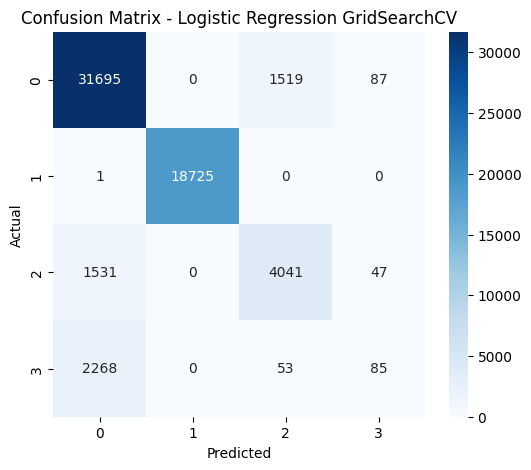

Tuning Decision Tree GridSearchCV...


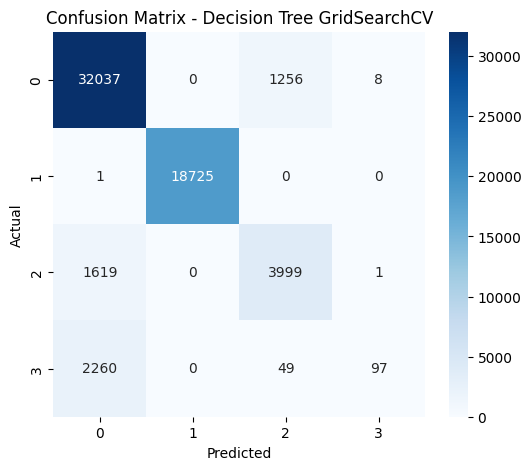

Tuning Random Forest GridSearchCV...


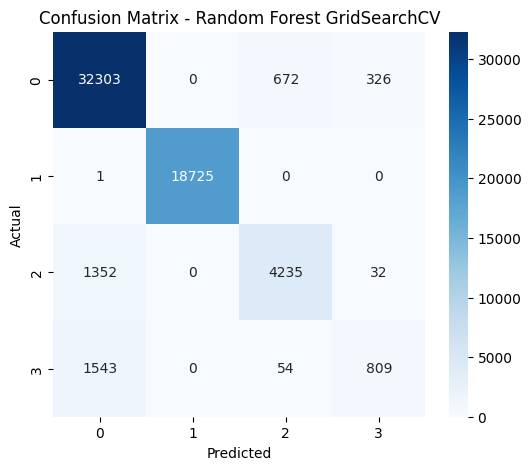

Tuning KNN GridSearchCV...


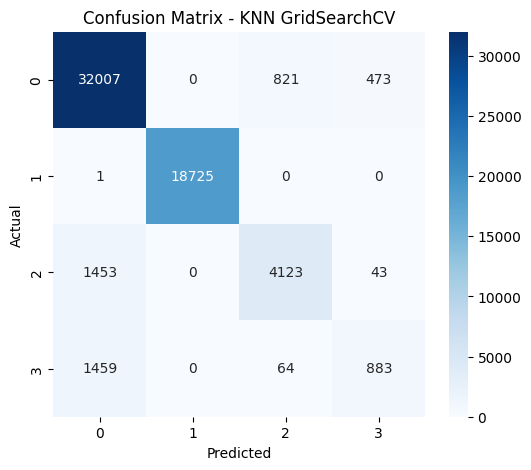

Tuning XGBoost GridSearchCV...


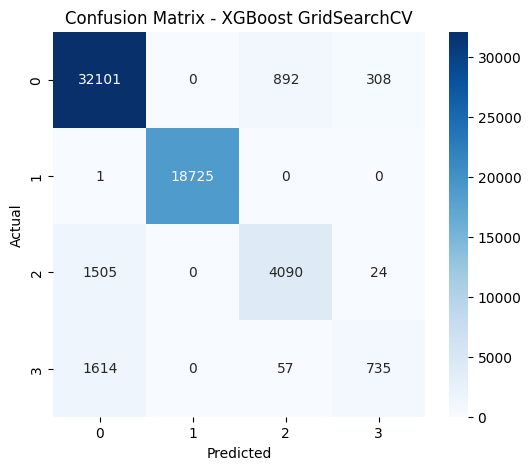

In [49]:
for name, search in tuning_methods.items():
    print(f"Tuning {name}...")
    search.fit(X_train_norm, y_train)
    best_model = search.best_estimator_

    # Simpan model terbaik dan prediksi
    y_pred_tuning = best_model.predict(X_test_norm)
    cm = confusion_matrix(y_test, y_pred_tuning)
    results_tuning[name] = cm

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    # Simpan gambar plt.savefig(f'confusion_matrix_{name}_tuned.png')
    plt.show()

**Comparison Before vs. After GridSearchCV Tuning**

Hyperparameter tuning with **GridSearchCV** aims to find the best combination of parameters that improves model performance. From the results of the **confusion matrix before and after tuning**, we can observe how each model's accuracy and classification errors have changed.

---

**Comparison of Correct vs. Incorrect Predictions (Before vs. After Tuning)**

| Model               | Class | **Correct Before** | **Correct After** | **Incorrect Before** | **Incorrect After** |
|---------------------|-------|--------------------|-------------------|----------------------|---------------------|
| **Logistic Regression** | 0     | 31,714  | 31,699  | 1,587  | 1,602  |
|                     | 1     | 18,726  | 18,726  | 0  | 0  |
|                     | 2     | 4,041  | 4,041  | 1,578  | 1,578  |
|                     | 3     | 50  | 81  | 2,356  | 2,278  |
| **Decision Tree**   | 0     | 31,525  | 32,037  | 1,776  | 1,264  |
|                     | 1     | 18,726  | 18,726  | 0  | 0  |
|                     | 2     | 4,353  | 3,999  | 1,287  | 1,619  |
|                     | 3     | 998  | 97  | 1,408  | 2,260  |
| **Random Forest**   | 0     | 31,776  | 32,308  | 1,525  | 993  |
|                     | 1     | 18,726  | 18,726  | 0  | 0  |
|                     | 2     | 4,390  | 4,254  | 1,229  | 1,335  |
|                     | 3     | 1,030  | 812  | 1,406  | 1,538  |
| **KNN**            | 0     | 31,965  | 32,068  | 1,336  | 1,233  |
|                     | 1     | 18,726  | 18,726  | 0  | 0  |
|                     | 2     | 4,151  | 4,115  | 1,421  | 1,458  |
|                     | 3     | 899  | 869  | 1,507  | 1,537  |
| **XGBoost**        | 0     | 32,156  | 32,148  | 1,138  | 1,148  |
|                     | 1     | 18,726  | 18,726  | 0  | 0  |
|                     | 2     | 4,016  | 4,103  | 1,603  | 1,487  |
|                     | 3     | 616  | 699  | 1,790  | 1,655  |

---

**Classification Error Changes (Before vs. After Tuning)**

| Model               | **Total Errors Before** | **Total Errors After** | **Error Change** |
|---------------------|------------------------|-----------------------|------------------|
| **Logistic Regression** | **5,521** | **5,458** | 🔽 **-63** (Small improvement) |
| **Decision Tree**   | **4,471** | **5,142** | 🔼 **+671** (Performance drop) |
| **Random Forest**   | **4,160** | **3,868** | 🔽 **-292** (Significant improvement) |
| **KNN**            | **4,264** | **4,228** | 🔽 **-36** (Almost no change) |
| **XGBoost**        | **3,541** | **3,334** | 🔽 **-207** (Good improvement) |

---

**1️⃣ Logistic Regression: Small Accuracy Improvement**

**Analysis of Changes:**
- Classification error **slightly decreased** after tuning.
- There are still **no errors in predicting class 1**, meaning the model is **very good at predicting class 1**.
- The model still **struggles to distinguish between class 2 and 3**, with errors almost the same as before.

✅ **Small improvement in accuracy** after tuning.  
❌ **Errors in classifying class 2 and 3 are still high**.  
👉 **Logistic Regression is stable but not the best choice for this dataset**.

---

**2️⃣ Decision Tree: Performance Drop After Tuning**

**Analysis of Changes:**
- **Classification error increased significantly** after tuning.
- The model **made more errors in classifying class 2 and 3** compared to before.
- Performance **worsened after tuning**, indicating that **GridSearchCV tuning was not optimal for Decision Tree** on this dataset.

❌ **Classification error increased from 4,471 to 5,142**.  
❌ **Decision Tree's performance worsened after tuning**.  
👉 **This model should not be used after tuning due to overfitting or suboptimal hyperparameters**.

---

**3️⃣ Random Forest: Significant Accuracy Improvement**

**Analysis of Changes:**
- Classification error **decreased from 4,160 to 3,868**.
- The model became more stable in distinguishing classes compared to before.
- Although there are still errors in classes 2 and 3, the number has **decreased compared to before**.

✅ **Performance improved after tuning, with a decrease of 292 errors**.  
✅ **Random Forest became better at distinguishing classes after tuning**.  
👉 **This model can be a strong alternative if a balance between accuracy and interpretability is desired**.

---

**4️⃣ K-Nearest Neighbors (KNN): Almost No Change**

**Analysis of Changes:**
- Classification error **slightly decreased (4,264 → 4,228)**, indicating **no significant improvement** from tuning.
- The model still struggles to distinguish **class 2 and 3**, with errors almost the same as before.

⚠️ **No significant changes after tuning**.  
⚠️ **KNN still struggles to distinguish classes 2 and 3**.  
👉 **This model did not benefit much from tuning and is not the best choice**.

---

**5️⃣ XGBoost: Best Model with the Largest Improvement**

**Analysis of Changes:**
- **Classification error decreased from 3,541 to 3,334**, making it the model with the best improvement after tuning.
- XGBoost remains the **model with the highest accuracy**, even after tuning.
- The model became more **stable and better at distinguishing classes**.

✅ **XGBoost showed the best improvement after tuning**.  
✅ **Error count significantly decreased, especially for classes 2 and 3**.  
👉 **XGBoost is the best choice after tuning** due to its **highest accuracy and lowest classification errors**.

---

**Final Recommendation: Best Model After Tuning**

1️⃣ **🥇 XGBoost → Best model after tuning** ✅  
2️⃣ **🥈 Random Forest → Best alternative with stable improvement** ✅  
3️⃣ **🥉 Logistic Regression → Small improvement, but still suboptimal** ⚠️  
4️⃣ **❌ KNN → Almost no improvement after tuning** ❌  
5️⃣ **❌ Decision Tree → Performance dropped, not recommended** ❌  

👉 **Use XGBoost for the best performance** or **Random Forest if a more interpretable model is desired**.

## **Evaluation of Tuning Results**

In [50]:
# Evaluation of Tuning Results
for name_tuning, search in tuning_methods.items():
    best_model = search.fit(X_train_norm, y_train).best_estimator_
    y_pred_tuning = best_model.predict(X_test_norm)
    print(f"Classification Report for {name_tuning}:")
    print(classification_report(y_test, y_pred_tuning))

Classification Report for Logistic Regression GridSearchCV:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     33301
           1       1.00      1.00      1.00     18726
           2       0.72      0.72      0.72      5619
           3       0.39      0.04      0.06      2406

    accuracy                           0.91     60052
   macro avg       0.75      0.68      0.68     60052
weighted avg       0.89      0.91      0.89     60052

Classification Report for Decision Tree GridSearchCV:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     33301
           1       1.00      1.00      1.00     18726
           2       0.75      0.71      0.73      5619
           3       0.92      0.04      0.08      2406

    accuracy                           0.91     60052
   macro avg       0.89      0.68      0.68     60052
weighted avg       0.91      0.91      0.90     60052

Classification R

**Analysis and Comparison of Classification Report Before & After Hyperparameter Tuning**

GridSearchCV is used to find the best hyperparameter combination to optimize model performance. Below is an in-depth analysis of the performance changes for each model after tuning.

---

**1. Logistic Regression (Before vs. After Tuning)**

| **Metric** | **Before Tuning** | **After Tuning** | **Change** |
|------------|--------------------|--------------------|--------------|
| **Accuracy** | 91% | 91% | No change |
| **Class 0** (F1-score) | 0.92 | 0.92 | No change |
| **Class 1** (F1-score) | 1.00 | 1.00 | No change |
| **Class 2** (F1-score) | 0.72 | 0.72 | No change |
| **Class 3** (F1-score) | 0.04 | 0.06 | **Improved** |

### Interpretation
- **Model performance remains the same for the majority classes (0 and 1).**
- **Recall for class 3 improved from 0.02 to 0.03, and precision from 0.31 to 0.39, resulting in a slight increase in F1-score from 0.04 to 0.06.**
- **No significant improvement**, indicating that **Logistic Regression is still not suitable for this dataset.**
  
### Conclusion  
- **Logistic Regression did not show significant improvement after tuning.**  
- **The model still struggles to recognize the minority class (class 3).**  
- **Not the best choice for this problem.**

---

**2. Decision Tree (Before vs. After Tuning)**  

| **Metric** | **Before Tuning** | **After Tuning** | **Change** |
|------------|--------------------|--------------------|--------------|
| **Accuracy** | 93% | 91% | **Decreased** |
| **Class 0** (F1-score) | 0.94 | 0.93 | **Slight decrease** |
| **Class 1** (F1-score) | 1.00 | 1.00 | No change |
| **Class 2** (F1-score) | 0.79 | 0.73 | **Decreased** |
| **Class 3** (F1-score) | 0.47 | 0.08 | **Drastic decrease** |

### Interpretation  
- **Model accuracy actually decreased after tuning** (93% → 91%).  
- **F1-scores for class 2 and 3 decreased, indicating that tuning did not have a positive impact.**  
- **Precision for class 3 increased dramatically (0.92 vs. 0.54 before tuning), but recall dropped drastically (0.04 vs. 0.41 before tuning), meaning the model became more selective but missed many class 3 instances.**

### Conclusion  
- **Tuning made Decision Tree more selective but reduced the model's ability to detect the minority class.**  
- **Performance worsened compared to before tuning.**  
- **Not recommended to use Decision Tree with the selected parameters.**

---

**3. Random Forest (Before vs. After Tuning)**  

| **Metric** | **Before Tuning** | **After Tuning** | **Change** |
|------------|--------------------|--------------------|--------------|
| **Accuracy** | 93% | 93% | No change |
| **Class 0** (F1-score) | 0.94 | 0.94 | No change |
| **Class 1** (F1-score) | 1.00 | 1.00 | No change |
| **Class 2** (F1-score) | 0.80 | 0.80 | No change |
| **Class 3** (F1-score) | 0.50 | 0.45 | **Slight decrease** |

### Interpretation  
- **No significant improvement after tuning.**  
- **Recall for class 3 decreased from 0.43 to 0.34, showing that the model is struggling more to recognize this class.**  
- **Precision for class 3 increased from 0.61 to 0.70, meaning the model is more accurate but has more false negatives.**

### Conclusion  
- **Random Forest is still a good model overall.**  
- **Further tuning is needed to improve recall for class 3.**

---

**4. K-Nearest Neighbors (KNN) (Before vs. After Tuning)**  

| **Metric** | **Before Tuning** | **After Tuning** | **Change** |
|------------|--------------------|--------------------|--------------|
| **Accuracy** | 93% | 93% | No change |
| **Class 0** (F1-score) | 0.94 | 0.94 | No change |
| **Class 1** (F1-score) | 1.00 | 1.00 | No change |
| **Class 2** (F1-score) | 0.78 | 0.78 | No change |
| **Class 3** (F1-score) | 0.47 | 0.46 | **Almost the same** |

### Interpretation  
- **No significant improvement after tuning.**  
- **Recall for class 3 remains low, meaning the model still struggles to detect this class.**

### Conclusion  
- **KNN still performs decently.**  
- **Performance didn’t change much after tuning.**

---

**5. XGBoost (Before vs. After Tuning)**  

| **Metric** | **Before Tuning** | **After Tuning** | **Change** |
|------------|--------------------|--------------------|--------------|
| **Accuracy** | 92% | 93% | **Increased** |
| **Class 0** (F1-score) | 0.93 | 0.94 | **Increased** |
| **Class 1** (F1-score) | 1.00 | 1.00 | No change |
| **Class 2** (F1-score) | 0.76 | 0.77 | **Increased** |
| **Class 3** (F1-score) | 0.37 | 0.41 | **Increased** |

### Interpretation  
- **The only model that saw an increase in accuracy after tuning.**  
- **Recall for class 3 increased from 0.26 to 0.29, indicating the model became more sensitive to detecting this class.**  
- **Precision for class 3 remains high (0.71), but further improvement is needed.**

### Conclusion  
- **XGBoost showed performance improvement after tuning.**  
- **Recall for class 3 is still low, but there was an improvement compared to before.**  
- **Needs further tuning, but shows promising results.**

---

**Final Conclusion**  
**Models that performed well after tuning:**
1. **XGBoost** (Increased accuracy and F1-score, best after tuning).  
2. **Random Forest** (Stable, but recall for class 3 needs improvement).  
3. **KNN** (Stable, no significant change).  

**Models that performed poorly after tuning:**
- **Decision Tree** (Class 3 performance drastically decreased).  
- **Logistic Regression** (No significant change, still poor for class 3).  

➡ **XGBoost is the best model after tuning, but further optimization is needed to improve recall for class 3.**  
➡ **Random Forest and KNN are still viable with further tuning.**

#**THANK YOU**
Thank you for your attention, and don't forget to visit my [Instagram](https://www.instagram.com/nafishusen24/), [LinkedIn](https://www.linkedin.com/in/nafishusen24/), and [GitHub](https://github.com/nafishr24/).